# **Análisis completo de de la base de datos 2019-Nov.csv**

## Introdución


En esta parte del código inicamos cargando la base de datos, la cual se encuentra subida en drive, así como su limpieza y un pequeño análisis exploratorio.

In [ ]:
# Instalamos las librerías necesarias para llevar a cabo las tareas pedidas
#!pip install --upgrade dask pandas pyarrow fsspec

In [ ]:
#Importamos las librerías necesarias para este análisis

import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


# Abrimos el archivo csv
ruta_archivo = "/content/drive/MyDrive/datos_descomprimidos/2019-Nov.csv"
datos = dd.read_csv(ruta_archivo, dtype_backend='numpy_nullable')
#Desplegamos la cabeza del DataFrame para visualizar un poco la estructura
datos.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,<NA>,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


En esta parte se inicia el proceso de exploración y limpieza. En principio se grafica el número de clases distintas en la variable o columna *event_type*, después se muestra una tabla con las columnas que tienen valores faltantes "NaN", para ver cómo los podemos eliminar y si se pierde información importante al realizar dicha acción.

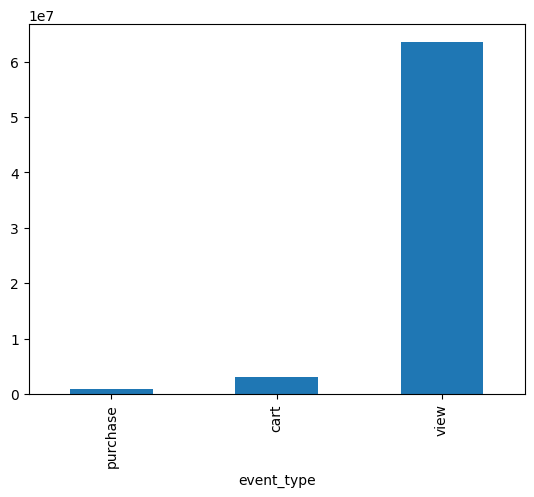

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,21898171
brand,9224078
price,0
user_id,0
user_session,10


In [ ]:
#calculamos los valores de cada evento
valosres_unicos = datos["event_type"].value_counts().compute()
#Visualizamos rápidamente los resultados
valosres_unicos.plot(kind='bar')
plt.show()

# Contamos los  nulos por columna
nulos_por_columna = datos.isnull().sum()
nulos_por_columna = nulos_por_columna.compute()
nulos_por_columna

Observamos en la grafica anterior que el evento "vew" es bastante frecuente, pues sobrepasa $6 \times 10^7$.

También observamos que falta en la base de datos el evento " remove_from_cart" en una busqueda exaustiva de ese evento el resultado fue $0$, por lo que no se realizó el filtro pedido, pues al final resulta la misma base de datos.

Además se observa que los valores faltantes son más frecuentes en las variables "category_code" y "brand", por lo que se decidió eliminar esas variables y que además tuvieran event_type como "view", ya que si vieron el producto no nos dice mucho.

Así en el siguiente bloque de código se realiza la limpieza, agregamos columnas importantes y se realizan los conteos necesarios para la resolución de las preguntas estipuladas en el documento de prueba.

In [ ]:
# Condición 1: category_code es nulo y event_type es 'view'
cond1 = (datos["category_code"].isnull()) & (datos["event_type"] == "view")

# Condición 2: brand es nulo y event_type es 'view'
cond2 = (datos["brand"].isnull()) & (datos["event_type"] == "view")

# Unimos las dos condiciones con OR
condiciones_a_eliminar = cond1 | cond2

# Eliminamos esas filas
datos_limpios = datos[~condiciones_a_eliminar]

#Eliminamos la columna user_session
datos_limpios = datos_limpios.drop(["user_session"], axis = 1)

#convertimos a datetime la columna event_type
datos_limpios["event_time"] = dd.to_datetime(datos_limpios["event_time"], errors='coerce')


#Agregamos nuevas columnas
# Día de la semana como texto
datos_limpios["dia_semana"] = datos_limpios["event_time"].dt.day_name()

# Hora como número entero entre 0 y 23
datos_limpios["hora"] = datos_limpios["event_time"].dt.hour
#Columna de si es compra 1 o no 0
datos_limpios["es_compra"] = (datos_limpios["event_type"] == "purchase").astype("int")


##**Desarrollo y Análisis**

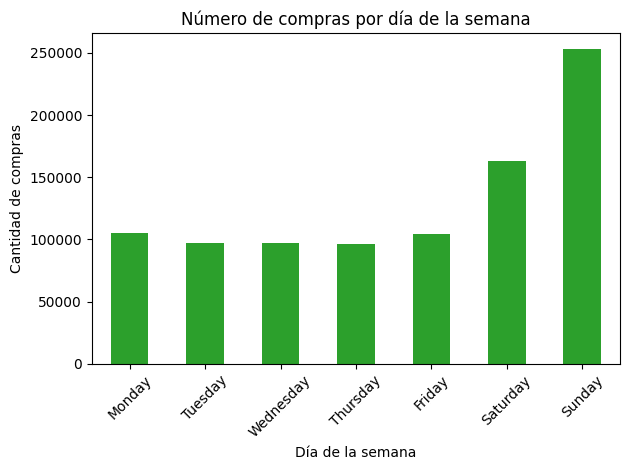

In [ ]:
compras = datos_limpios[datos_limpios["event_type"] == "purchase"]
# Agrupar por 'dia_semana'
compras_por_dia = compras.groupby("dia_semana").size().compute()
# Aseguramos orden correcto de los días
orden_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
compras_por_dia = compras_por_dia.reindex(orden_dias)

#Graficamos rapidamente
compras_por_dia.plot(kind="bar", color="#2ca02c")

plt.title("Número de compras por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Cantidad de compras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En el gráfico anterior se observa que los usuarios compran en Domingo, lo cual tiene muchon sentido ya que en domingo normalmente las personas descansan y tienen tempo de comprar.

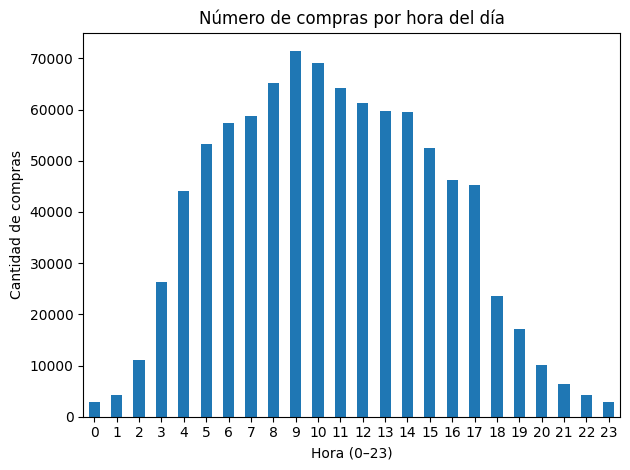

In [ ]:
compras_por_hora = compras.groupby("hora").size().compute()
compras_por_hora = compras_por_hora.sort_index()

#graficamos
compras_por_hora.plot(kind="bar", color="#1f77b4")

plt.title("Número de compras por hora del día")
plt.xlabel("Hora (0–23)")
plt.ylabel("Cantidad de compras")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Respondiendo a la pregunta 2, el horario en el que las personas suelen comprar copn mayor frecuencia es entre las 8h-12h.

In [ ]:
num_totalc = len(compras)
vistas = datos_limpios[datos_limpios["event_type"] == "view"]
num_totalv = len(vistas)
tasa_conv_gen = num_totalc / num_totalv
print(f"Tasa de conversión general: {tasa_conv_gen}")

Tasa de conversión general: 0.023322745238702175


En lo anterior vemos que la tasa de conversión es de apriximadamente $0.0233$, respondiendo aquí la priemr pregunta de la prueba.

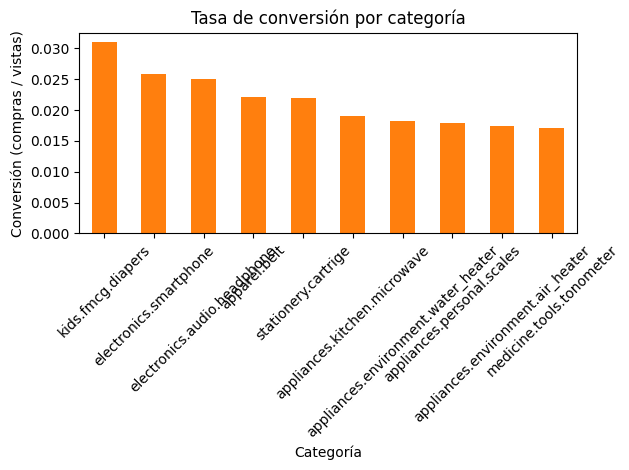

In [ ]:
#Tasa de conversión por categoría de las primeras 10 más altas
vistas_por_categoria = vistas["category_code"].value_counts().compute()
compras_por_categoria = compras["category_code"].value_counts().compute()
# Calculamos la tasa
conversion_por_categoria = (compras_por_categoria / vistas_por_categoria).fillna(0)
conversion_por_categoria = conversion_por_categoria.sort_values(ascending=False)

conversion_por_categoria.head(10).plot(kind="bar", color="#ff7f0e")
plt.title("Tasa de conversión por categoría")
plt.ylabel("Conversión (compras / vistas)")
plt.xlabel("Categoría")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


En el gráfico anterior observamos las $10$ tasas más grandes por categoría, observamos que la tasa más grande es la categoria "kids.fmcg.diapers" que tiene que ver con productos para niños, en segundo lugar están los electronicos de smarphone, con esto respondemos a la pregunta número $3$.

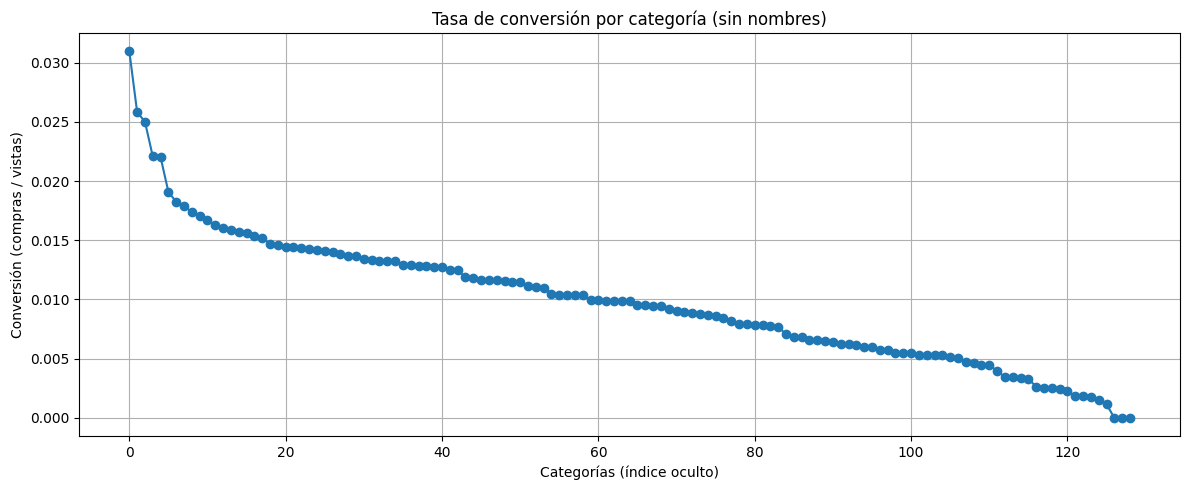

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(conversion_por_categoria.values, marker='o', linestyle='-', color='#1f77b4')

plt.title("Tasa de conversión por categoría (sin nombres)")
plt.ylabel("Conversión (compras / vistas)")
plt.xlabel("Categorías (índice oculto)")
plt.grid(True)
plt.tight_layout()
plt.show()

En el gráfico anterior observamos todas las tasas por categoría sin nimbre, ya que son aproximadamente 130 categorías.

In [ ]:
carrito = datos_limpios[datos_limpios["event_type"] == "cart"]
num_total_carritos = len(carrito)
num_total_carritos

3028930

Observamos que $3028930$ son los usuarios que sólo agrgaron al carrito, respondiendo así la pregunta  $4$. Y como respuesta a la pregunta $5$ no hay dicha variable, lo que da como resultado $0$.

## **Conclusiones**
Durante el análisis se observó que el mayor volumen de compras ocurre los domingos, especialmente entre las 8 y las 12 horas, lo cual sugiere que los usuarios aprovechan su tiempo libre para realizar compras. Además, la categoría con mayor tasa de conversión es "kids.fmcg.diapers", lo que indica una fuerte intención de compra en productos para bebés, posiblemente por tratarse de artículos de primera necesidad.

Como propuesta de marketing, se recomienda lanzar campañas promocionales orientadas a productos infantiles los domingos por la mañana, incluyendo descuentos temporales o combos atractivos. En cuanto a segmentación, se sugiere enfocar los esfuerzos en usuarios con historial de navegación o compra en categorías infantiles.